# TIM : Detection of points of interest

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import itertools
from scipy.ndimage.interpolation import shift

path_base =  '..//Base_images//'
# source des équations : https://courses.cs.washington.edu/courses/cse576/06sp/notes/HarrisDetector.pdf

C:\Users\Hasan\AppData\Local\Temp\ipykernel_13416\3822525759.py:5: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


# 1- Harris detector - getting started

In the image, some points are distinguished by their intensity compared to their neighborhood indicating a sudden change in the intensity of gray levels and / or the change of orientation of a curve (inflection point or corner). There are several detectors of points of interest. We propose to implement here the Harris detector. This one considers the differences (squared) of intensity around a point and this for all points of the image.


1. Create a 150x150 image with a black square on a white background (chessboard) that you save as a checkboard

Translated with www.DeepL.com/Translator (free version)

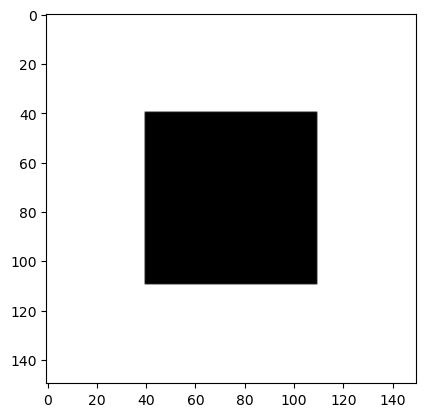

In [2]:
## Code here
h, w = 150, 150
px1 = 255
px2 = 0
checkboard = np.full((h,w),px1)
checkboard[40:110, 40:110] = 1
plt.imshow(checkboard, 'gray')

# 2- Harris algorithm

The principle of Harris is to calculate the changes of intensity in the image in all directions. Three situations arise from the calculation of the energy E 

- Situation 1: The intensity is approximately constant in the image area considered: the function E will then take low values in all directions (x, y).
- Situation 2 : The considered image area contains a rectilinear contour : the E function will then take low values for displacements (x,y) along the contour and high values for displacements perpendicular to the contour.
- Situation 3: The considered image area contains a corner or an isolated point (point of interest): the E function will take strong values in all directions.

The calculation of the values according to the directions is done naturally by calculating the directional derivatives in each pixel. 

2. Calculate the derivatives Ix and Iy of the image


Translated with www.DeepL.com/Translator (free version)

In [4]:
checkboard_float = checkboard.astype(np.float32)

# Calculate derivatives using Sobel filter
Ix = cv2.Sobel(checkboard_float, cv2.CV_64F, 1, 0, ksize=3)
Iy = cv2.Sobel(checkboard_float, cv2.CV_64F, 0, 1, ksize=3)

3. Calculate (elementwise)

\begin{equation*}
    a = (\frac{dI}{dx})^{2}
\end{equation*}

\begin{equation*}
    b = (\frac{dI}{dx})\dot(\frac{dI}{dy})
\end{equation*}


\begin{equation*}
    c = (\frac{dI}{dy})^{2}
\end{equation*}


In [5]:
a = Ix**2
b = Ix * Iy
c = Iy**2

# Harris R operator
4. Calculate lambda 1 and lambda 2 the principal axes of the E ellipse for each pixel.

In [6]:
trace_H = a + c
det_H = a * c - b**2


lambda1 = 0.5 * (trace_H + np.sqrt(trace_H**2 - 4 * det_H))
lambda2 = 0.5 * (trace_H - np.sqrt(trace_H**2 - 4 * det_H))

5. Plot the images lamda 1 and lamda 2. What do you think? 

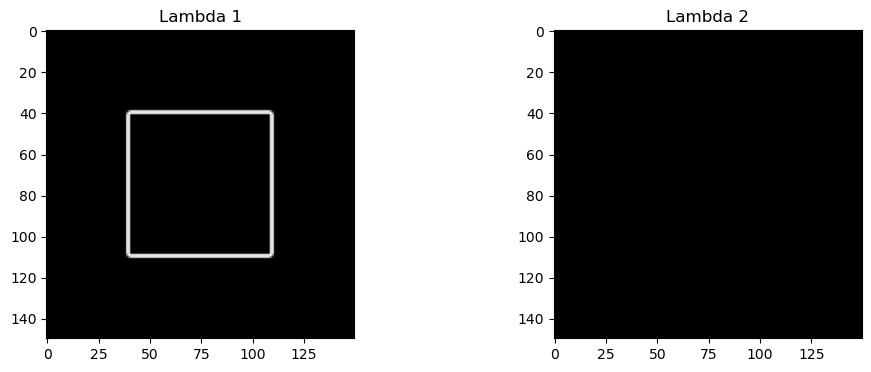

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(lambda1, 'gray')
plt.title('Lambda 1')

plt.subplot(1, 2, 2)
plt.imshow(lambda2, 'gray')
plt.title('Lambda 2')

plt.show()

6. Compute the Harris R operator with 0.04 < k <0.06

In [10]:
k = 0.04

R = lambda1 * lambda2 - k * (lambda1 + lambda2)**2

7. Plot the image R

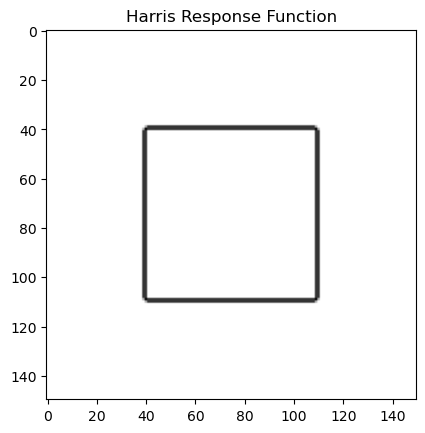

In [11]:
plt.imshow(R, 'gray')
plt.title('Harris Response Function')
plt.show()

8. Create a function that takes as input the original image and gives as output the image R = Harris_Oprator(img)

In [29]:
def Harris_Operator(img_path, k=0.04):
    original_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if original_image is None:
        raise ValueError(f"Error loading the image from {img_path}")

    Ix = cv2.Sobel(original_image.astype(np.float32), cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(original_image.astype(np.float32), cv2.CV_64F, 0, 1, ksize=3)

    a = Ix ** 2
    b = Ix * Iy
    c = Iy ** 2

    trace_H = a + c
    det_H = a * c - b**2

    lambda1 = 0.5 * (trace_H + np.sqrt(trace_H**2 - 4 * det_H))
    lambda2 = 0.5 * (trace_H - np.sqrt(trace_H**2 - 4 * det_H))

    R = lambda1 * lambda2 - k * (lambda1 + lambda2)**2

    return R
img_path = 'lena_gray.tif'
harris_response = Harris_Operator(img_path)

# 3- Detection of points of interest

The points of interest are the pixels for which R>0 (R<0 : contour, abs(R) very small: homogeneous area)

9. Choose the threshold t of your choice on the image R to detect the most salient points of interest.

In [30]:
threshold = 0.01

# Detect points of interest
interest_points = (harris_response > threshold).astype(np.uint8) * 255

10. Correct your function to have another function Harris_Corner_Detector(img, N) that outputs the points of interest directly on the image img where N is the number of points of interest to detect. 

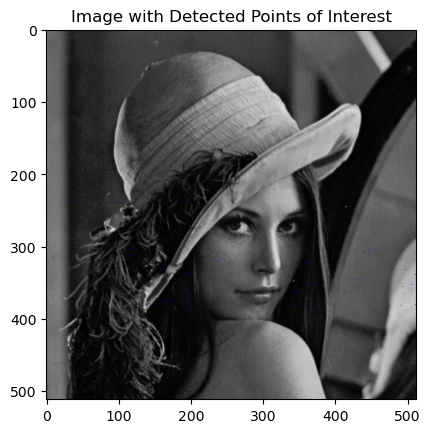

In [32]:
def Harris_Corner_Detector(img_path, N=100, k=0.04):
    original_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if original_image is None:
        raise ValueError(f"Error loading the image from {img_path}")

    Ix = cv2.Sobel(original_image.astype(np.float32), cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(original_image.astype(np.float32), cv2.CV_64F, 0, 1, ksize=3)

    a = Ix ** 2
    b = Ix * Iy
    c = Iy ** 2

    trace_H = a + c
    det_H = a * c - b**2

    lambda1 = 0.5 * (trace_H + np.sqrt(trace_H**2 - 4 * det_H))
    lambda2 = 0.5 * (trace_H - np.sqrt(trace_H**2 - 4 * det_H))

    R = lambda1 * lambda2 - k * (lambda1 + lambda2)**2

    # Choose the top N points of interest
    interest_points = np.zeros_like(R, dtype=np.uint8)
    flat_indices = np.argpartition(R.flatten(), -N)[-N:]
    rows, cols = np.unravel_index(flat_indices, R.shape)
    interest_points[rows, cols] = 255

    # Overlay points of interest on the original image
    img_with_interest = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)
    img_with_interest[interest_points > 0] = [0, 0, 255]  # Red color for points

    return img_with_interest

# Example usage:
img_path = 'lena_gray.tif'
result_image = Harris_Corner_Detector(img_path, N=100)

# Display the result image
plt.imshow(result_image)
plt.title('Image with Detected Points of Interest')
plt.show()


# 3 - Application
11. Apply your function on the image lena_gray.tif with 50 points of interest detected

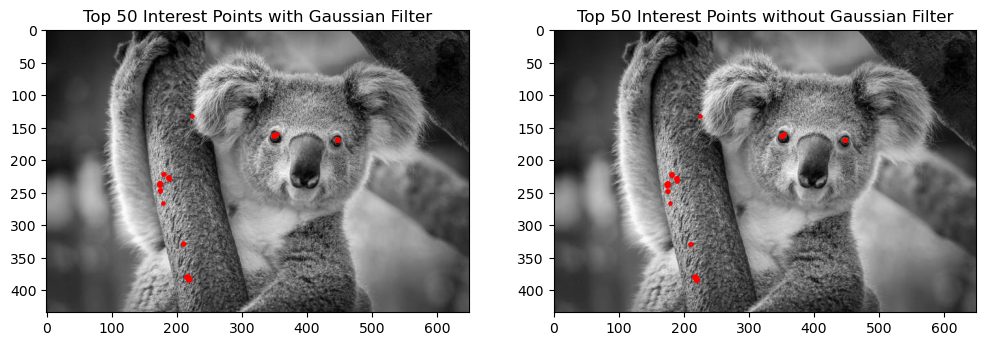

In [38]:
import numpy as np
from skimage import io, color, feature
import matplotlib.pyplot as plt

def Harris_Corner_Detector_Gaussian(image, N):
    corners = feature.corner_harris(image)
    interest_points = np.argpartition(corners.flatten(), -N)[-N:]
    interest_points = np.unravel_index(interest_points, corners.shape)
    return interest_points

lena_path = 'koala.jpg'
lena_img = io.imread(lena_path)

if len(lena_img.shape) == 3 and lena_img.shape[2] == 4:
    lena_gray = color.rgb2gray(lena_img[:, :, :3])
else:
    lena_gray = color.rgb2gray(lena_img)

N = 50
interest_points_lena_gaussian = Harris_Corner_Detector_Gaussian(lena_gray, N)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(lena_gray, cmap='gray')
plt.scatter(interest_points_lena_gaussian[1], interest_points_lena_gaussian[0], color='red', s=5)
plt.title(f'Top {N} Interest Points without Gaussian Filter')



plt.show()


12. Repeat the same process by filtering A, B and C by a Gaussian filter of size 5x5. Is the detection result improved ?


In [ ]:
# Code here


# Bonus
13. Incorporate in your function the NMS: a filter of size 7x7 sliding on the image R which allows to choose the pixel having the maximum value.

In [ ]:
# Code here
